**Detect Nuceli in .ome File lists**

Aim : To load, threshold, and detect nuceli for futher analysis.

In [ ]:
import os

In [ ]:
#Get file list
path='C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/'
filelist=os.listdir(path)
filelist

In [46]:
#[1] Get targeted filelist
import glob
path='C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/'

target='.ome.tif'

filelist=glob.glob(path+str('*')+target)

In [ ]:
#Specify output directory
output='Output/'
newpath = path+output
if not os.path.exists(newpath):
    os.makedirs(newpath)

**Define Image processing functions**

Having generated a list of our input files and specified an output folder, 
we now need to define the functions required by our pipeline

In [83]:
import skimage.io as io
io.use_plugin('tifffile')

#load Hoechst and GFP stacks from .ome.tif files
def load_ome(ome_stack_file):

    #MMStack .ome.tif files load channel,z,y,x
    #Check file contains .ome.tif
    if '.ome.tif' in ome_stack_file:

        #Load the file
        im=io.imread(ome_stack_file)

        #Select Hoechst stack
        Hoechst_stack = im[0,:,:,:] #Hoechst Channel = 0
        GFP_stack = im[1,:,:,:]     #GFP Channel = 1
        
        #
        return [Hoechst_stack, GFP_stack]
        #return GFP_stack
        
    else:
        print 'this is not an ome.tif'

In [199]:
##Extract channel information for a given file
[Hoechst_stack, GFP_stack] = load_ome(filelist[4])

In [ ]:
# ##Segment Nuclei
# import skimage.io as io
# io.use_plugin('tifffile')

# #Load image
# im = io.imread('C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Well02_HeLa_PHD2-IDR-PHD3_1/Well02_HeLa_PHD2-IDR-PHD3_1.tif')

# #Slice1 contains ~58 nuclei, 52 not touching the border

# #Select Hoechst stack
# Hoechst_stack = im[:,:,:,0]

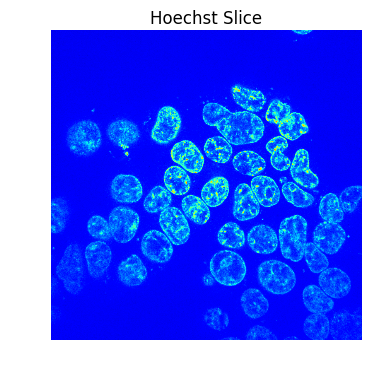

In [200]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(Hoechst_stack[4])
plt.axis('off')
plt.title('Hoechst Slice')

#Note uneven illumination

In [87]:
##Threshold a 3D stack (SLOW!)
def stack2mask(stack, gaussian_filter_size=3, radius = 50):
#By default gaussian_filter_size=3 for mask 2, and radius = 50 for mask4.
    
    #Calculate gaussianThresh 'mask2'
    mask2=gaussianThreshStack(Hoechst_stack, gaussian_filter_size)
    
    #Save 'mask2'
        
    #Calculate localOtsu 'mask4'
    mask4=localOtsuStack(stack, radius)

    #Save 'mask4'
    
    #Calculate mask5?
     
    return [mask2, mask4]    

In [103]:
##Try generating threshold masks from Hoechst stack
[mask2, mask4] = stack2mask(Hoechst_stack)

In [ ]:
##Remove background by intersecting with 3D gaussian filter mask
mask5 = np.logical_and(mask2, mask4)

In [79]:
#[1] Threshold by Gloabl Mean
def meanThreshStack(stack):
    return stack > stack.mean()

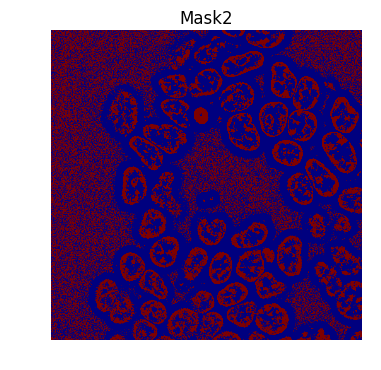

In [96]:
plt.imshow(mask4[0])
plt.axis('off')
plt.title('Mask2')

In [80]:
import mahotas as mh  #used for filtering and labeling binary regions

#[2] 3D Gaussian Filter then mean
def gaussianThreshStack(stack, gaussian_filter_size=3):
    #By default gaussian_filter_size is 3
    smoothed_stack = mh.gaussian_filter(stack, gaussian_filter_size) 
    return smoothed_stack > smoothed_stack.mean()

In [68]:
from skimage.filters import threshold_otsu, threshold_adaptive
#block_size and offset are optional arguments, with default parameters 35 and -20 respectively   
#block_size = Width of neighbourhood in pixels. Default was 35
#offset = Constant subtracted from mean. Default was 10

#[3] Try local threshold
def localThreshStack(stack, block_size = 35, offset = -20):

    #Must be a 2D array
    if len(stack.shape)>2:
        mask=np.zeros_like(stack)

        for z, frame in enumerate(stack):
            mask[z] = threshold_adaptive(frame, block_size, 'mean', offset)
        return mask     
    else:
        print 'Input is not a 3D stack'
        return threshold_adaptive(stack, block_size, 'mean', offset)
     

In [102]:
import numpy as np
from skimage.morphology import disk
from skimage.filters import threshold_otsu, rank
#from skimage.util import img_as_ubyte #Is this used?

#[4] Try local Otsu (Slow)
def localOtsuStack(stack, radius = 50):
#By default the radius is 50

    selem = disk(radius)

#Input must be a 2D array
    if len(stack.shape)>2:
        
        mask=np.zeros_like(stack)

        for z, frame in enumerate(stack):
            #print(z)
            local_otsu = rank.otsu(frame, selem)
            mask[z] = frame >= local_otsu
        return mask
    else:
        local_otsu = rank.otsu(stack, selem)         
        print 'Input is not a 3D stack'
        return stack >= local_otsu

In [ ]:
import numpy as np
import mahotas as mh  #used for filtering and labeling binary regions
from skimage.filters import threshold_otsu, threshold_adaptive

#Threshold the image
def stack2thres(stack, gaussian_filter_size, local_Otsu_radius)

    #[1] Mean
    #mask1=stack>stack.mean()

    #[2] 3D Gaussian Filter then mean
    smoothed_stack=mh.gaussian_filter(stack, 3)
    mask2 = smoothed_stack > smoothed_stack.mean()

    #[3] Try local threshold

    #Must be a 2D array
#     if len(stack.shape)>2:
#         mask3=np.zeros_like(stack)
#         block_size = 35 #Width of neighbourhood in pixels. Default was 35
#         offset = -20    #Constant subtracted from mean. Default was 10

#         for z, frame in enumerate(stack):
#             mask3[z] = threshold_adaptive(frame, block_size, 'mean', offset)
#     else:
#         mask3 = threshold_adaptive(stack, block_size, 'mean', offset)

    #[4] Try local Otsu (Slow)
    #from skimage.morphology import disk
    #from skimage.filters import threshold_otsu, rank
    #from skimage.util import img_as_ubyte

    #Select a single test image from the stack
    img = Hoechst_stack[4]

    radius = 50              #Default is 15, which looks good. 
                             #Tried nuclei size radius ~50, Bigger border around nuceli
                             #Tried nuclei size radius ~100. 
                             #Also tried r=5, worse for bright nuclei clustering
    selem = disk(radius)

    local_otsu = rank.otsu(img, selem)
    local_otsu_mask= img >= local_otsu

    #For comparison
    #threshold_global_otsu = threshold_otsu(img)
    #global_otsu = img >= threshold_global_otsu

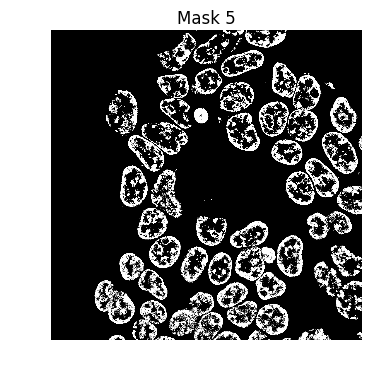

In [114]:
plt.imshow(mask5[5], cmap='gray')
plt.axis('off')
plt.title('Mask 5')

In [109]:
##Save mask4, it takes forever to run
np.save('C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Output/Well02_HeLa_PHD2-IDR-PHD3_2_Mask4', mask4)

In [111]:
##Remove background by intersecting with 3D gaussian filter mask
mask5 = np.logical_and(mask2, mask4)

In [115]:
##Save mask5
np.save('C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Output/Well02_HeLa_PHD2-IDR-PHD3_2_Mask5', mask5)

**Label the mask**

In [117]:
import mahotas as mh

labeled_mask5, nr_objects=mh.label(mask5)

In [124]:
z = int(13)

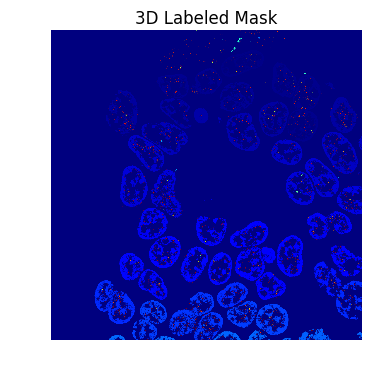

In [122]:
plt.imshow(labeled_mask5[z])
plt.axis('off')
plt.title('3D Labeled Mask')

In [120]:
##Remove small objects
from skimage import morphology

min_vol = 8000

#from skimage.morphology import remove_small_objects
real=morphology.remove_small_objects(labeled_mask5, min_vol)

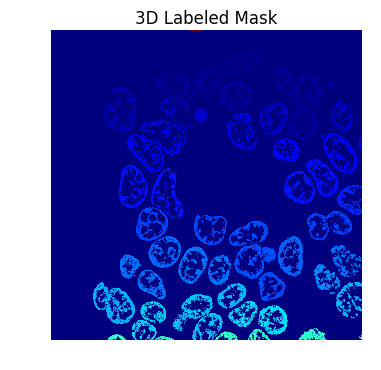

In [125]:
plt.imshow(real[z])
plt.axis('off')
plt.title('3D Labeled Mask')

In [129]:
##Count the labels, Reset counts (Maybe Randomize?), Find objects
relabeled, n_left = mh.labeled.relabel(real)
print('After filtering and relabeling, there are {} nuclei left.'.format(n_left))

After filtering and relabeling, there are 49 nuclei left.


In [130]:
##Save labeled mask
np.save('C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Output/Well02_HeLa_PHD2-IDR-PHD3_2_Labeled_Mask5', relabeled)

**Convert labeled image to filled objects**

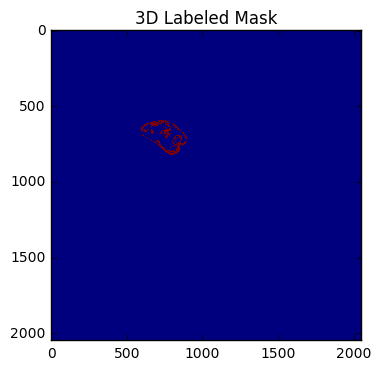

In [189]:
test=relabeled[z]==15
plt.imshow(test)
plt.title('3D Labeled Mask')

In [191]:
from scipy.ndimage import morphology

final=np.zeros_like(test)

for l in range(test.max()):
    ll=l+1
    #blob=morphology.binary_dilation(test==ll, np.ones((20,20)))
    filled_blob=morphology.binary_fill_holes(test)
    #reduced=morphology.binary_erosion(filled_blob, np.ones((20,20)))*ll
    #final=final+reduced

In [198]:
#Save
np.save('C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Output/Labeled_Mask_Test', filled_blob[500:1000,500:1000])

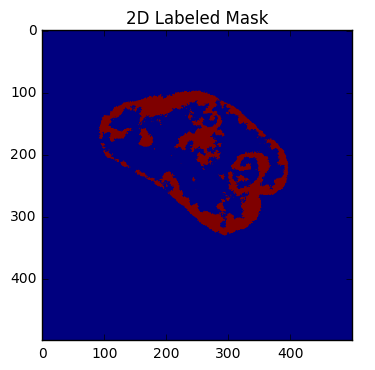

In [192]:
plt.imshow(filled_blob[500:1000,500:1000])
plt.title('2D Labeled Mask')

In [194]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature

temp=filled_blob[500:1000,500:1000]

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(temp)
edges2 = feature.canny(temp, sigma=3, )

AttributeError: 'module' object has no attribute 'set_title'

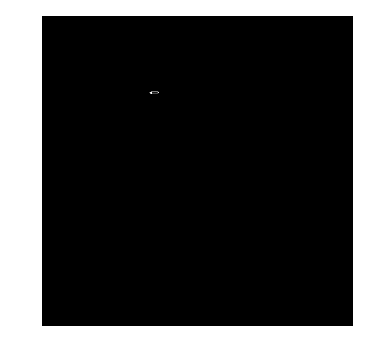

In [197]:
plt.imshow(edges2, cmap=plt.cm.gray)
plt.axis('off')
plt.set_title('Canny filter, $\sigma=1$', fontsize=20)

In [182]:
##Revist watershedding

##Doesn't work for a whole slice, but works well for single clusters.
image=relabeled[z]

from skimage import morphology
from skimage.feature import peak_local_max

from scipy import ndimage
distance = ndimage.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((150, 150)), labels=image)
markers = morphology.label(local_maxi)
labels_ws = watershed(-distance, markers, mask=image)

#from skimage import segmentation
# Transform markers image so that 0-valued pixels are to
# be labelled, and -1-valued pixels represent background
#markers[~image] = -1
#labels_rw = segmentation.random_walker(image, markers)

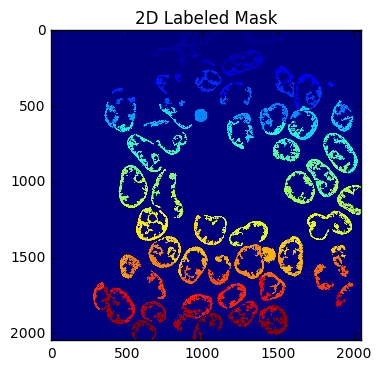

In [183]:
plt.imshow(labels_ws)
plt.title('2D Labeled Mask')